# Using satellite albedo data to monitor Sahara desert expansion
&nbsp;

Production date: 30-09-2024

Produced by: Consiglio Nazionale delle Ricerche ([CNR](https://www.cnr.it/en)
)

## 🌍 Use case: Estimating desertification using surface albedo data
## ❓ Quality assessment question
**• Can satellite albedo datasets be used to estimate the expansion of the Sahara desert?**

The Sahara, Earth’s largest hot desert, has expanded in recent decades. Existing studies indicates a sustained enlargement of the dry zone on both annual and seasonal timescales [1]. This implies risks to ecosystems, pastoral livelihoods, food and water security, and infrastructure across North and West Africa. Multiple regional studies document intensified desertification pressures in precisely the areas our analysis targets: sand‐dune encroachment around Nouakchott in Mauritania [2]; degradation and desertification sensitivity along the Algerian steppe, Sahara margin, where large‐scale countermeasures such as the “Green Dam” have been evaluated [3]; dune reactivation and wind‐erosion impacts in Niger [4]; active dune migration in the Libyan Ubārī Sand Sea [5]; and increased mobile dunes around Lake Chad and northern Chad since the 1970s [6].
In this assessment, we test whether satellite‐derived surface albedo from the Copernicus CDS (10-daily, 1-km; SPOT-VGT/PROBA-V, v2) can monitor desert expansion signals by mapping spatial albedo patterns and their changes comparing the data for two years, the winter season 2006-2007 and 2019-2020 (November to February, NDJF). Evaluating desertification during the NDJF period is crucial because this is often the dry season in many regions, making it the most vulnerable time for desertification to worsen. Albedo is a suitable proxy for surface state in arid lands because brightening often accompanies exposure or stabilization of bare sands and crusts, while darkening may reflect seasonal greening or increased surface moisture. Using seasonally consistent composites and quality screening, we quantify “desert-like” area via albedo masks and compute area changes on the native grid. The results reveal a small net increase in very bright desert‐like area across the Sahara, with the largest gains concentrated in the western–central Sahara (notably Mali and Mauritania), aligning with the independent evidence cited above [1–6]. This supports the use of CDS surface albedo data as a powerful tool for monitoring desertification dynamics and regional hotspots of change.


## 📢 Quality assessment statement
```{admonition} These are the key outcomes of this assessment
:class: note
* The seasonal albedo maps provide a clear, side-by-side view of surface reflectance in two benchmark years, making spatial changes in bright, desert-like areas easy to spot.

* The spatial resolution of the albedo data is sufficient to detect regional patterns in desert expansion, supporting effective monitoring of desertification processes.

```

## 📋 Methodology

The methodology adopted for the analysis is split into the following steps:

[](section-1)

   * Import all the relevant packages.
  
[](section-2)
   * Load monthly albedo data.
   * Inspect the dataset and extract albedo values over the Sahara region.
   * Apply quality-flag (QFLAG) filtering and define plotting helper functions.

[](section-3)

   * Generate maps of the Sahara study area with country boundaries and labels.

   * Detect and visualize Sahara Desert expansion using albedo data (NDJF, 2006–2019) and Produce an albedo change map (2019 − 2006).

   * Quantify desertification by country within the Sahara study domain.

   * Validate newly identified desert pixels and inspect their albedo values.

   * Perform pixel-count analysis comparing summer albedo maps (2006 vs. 2019).


     
[](section-4)

## 📈 Analysis and results
(section-1)=
### 1. Choose the data to use and set up the code

#### Import all the relevant packages
In this section, we import all the relevant packages required to run the notebook.

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
import geopandas as gpd
import xarray as xr
from datetime import datetime
from c3s_eqc_automatic_quality_control import download, utils, diagnostics
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from shapely.geometry import box, LineString
from cartopy.io import shapereader
plt.style.use("seaborn-v0_8-notebook")

(section-2)=
### 2. Data loading and preparation

#### Load monthly albedo data

This code retrieves monthly black-sky broadband albedo (albb_bh) data from the satellite-albedo collection over the central Sahara at 1 km resolution for the period 2006–2020, and computes time-weighted mean maps of albedo products for SPOT-VGT and PROBA-V sensors.

In [18]:
collection_id = "satellite-albedo"
chunks = {"year": 1}

common_request = {
    "format": "zip",
    "variable": "albb_bh",          
    "product_version": "v2",
    "month": [f"{m:02d}" for m in range(1, 13)],
    "nominal_day": "10",
    # Sahara (central belt): [north, west, south, east]
    "area": [28.0, -10.0, 15.0, 25.0],
}

requests = {
    "spot":  {"year": [str(y) for y in range(2006, 2014)], "horizontal_resolution": "1km", "sensor": "vgt"},
    "proba": {"year": [str(y) for y in range(2014, 2021)], "horizontal_resolution": "1km", "sensor": "vgt"},
}

maps = {}
series = {}
annual_maps = {}

for satellite, req in requests.items():
    print(f"{satellite=}")

    request = common_request | req | {"satellite": satellite}
    series[satellite] = download.download_and_transform(
        collection_id,
        request,
        chunks=chunks,
        transform_func=None,
        drop_variables=[],
    )

    maps[satellite] = download.download_and_transform(
        collection_id,
        request,
        chunks=chunks,
        transform_chunks=False,
        transform_func=diagnostics.time_weighted_mean,  # monthly→period mean
        drop_variables=["crs"],
    )

    annual_maps[satellite] = download.download_and_transform(
        collection_id,
        request,
        chunks=chunks,
        transform_chunks=False,
        transform_func=diagnostics.annual_weighted_mean,
        drop_variables=["crs"],
    )

satellite='spot'


100%|██████████| 8/8 [00:00<00:00, 99.65it/s]
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/earthkit/data/readers/netcdf/fieldlist.py:202: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  return xr.open_mfdataset(


satellite='proba'


100%|██████████| 7/7 [00:00<00:00, 114.60it/s]
/data/common/miniforge3/envs/wp5/lib/python3.12/site-packages/earthkit/data/readers/netcdf/fieldlist.py:202: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  return xr.open_mfdataset(


#### Inspect the dataset and extract albedo values over the Sahara region.

This step inspects the dataset structure and extracts a single monthly SPOT albedo slice (June 2006) as a DataFrame for validation.

In [19]:
for k, ds in series.items():
    print(f"\n=== {k.upper()} ===")
    print(ds)                 # dims, coords, data_vars
da = series["spot"]["AL_BH_BB"].sel(time="2006-06-10")
df_map = da.to_dataframe().reset_index()


=== SPOT ===
<xarray.Dataset> Size: 20GB
Dimensions:       (time: 96, latitude: 1456, longitude: 3920)
Coordinates:
  * time          (time) datetime64[ns] 768B 2006-01-10 ... 2013-12-10
  * latitude      (latitude) float64 12kB 28.0 27.99 27.98 ... 15.03 15.02 15.01
  * longitude     (longitude) float64 31kB -10.0 -9.991 -9.982 ... 24.98 24.99
Data variables:
    crs           (time) |S1 96B b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    AL_BH_BB      (time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 1456, 3920), meta=np.ndarray>
    AL_BH_BB_ERR  (time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 1456, 3920), meta=np.ndarray>
    AL_BH_NI      (time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 1456, 3920), meta=np.ndarray>
    AL_BH_NI_ERR  (time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 1456, 3920), meta=np.ndarray>
    AL_BH_VI      (time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 1456, 3920), meta=np

#### Apply quality-flag (QFLAG) filtering and define plotting helper functions.

This block defines helper functions to (1) apply QFLAG quality filtering by masking pixels based on specific bit tests, (2) compute seasonal/annual mean albedo after QC, (3) set map extents and plot maps with optional threshold contours, and (4) estimate grid-cell areas (km²) for area-based desertification statistics.

In [20]:

def qc_bits47(da_albedo: xr.DataArray, qflag: xr.DataArray) -> xr.DataArray:
    """
    Keep pixels where:
      Bit 4 == 0  (no missing/invalid input)
      Bit 7 == 0  (albedo processing OK)
    """
    q = qflag.astype("int")
    bit4_ok = (q & 16)  == 0     # 2**4
    bit7_ok = (q & 128) == 0     # 2**7
    return da_albedo.where(bit4_ok & bit7_ok)

def seasonal_mean_bits47(ds: xr.Dataset, months, year, also_require_bb_ok=False) -> xr.DataArray:
    """QC (bits 4 & 7 [+ optional bit 9]) → select months in `year` → mean over time."""
    da = ds["AL_BH_BB"]
    q  = ds["QFLAG"].astype("int")
    # base QC
    ok = ((q & 16) == 0) & ((q & 128) == 0)        # bits 4 and 7 clear
    if also_require_bb_ok:
        ok = ok & ((q & 256) == 0)                 # bit 9 clear
    da = da.where(ok)
    sel = da.sel(time=da.time.dt.year == year).where(da.time.dt.month.isin(months), drop=True)
    return sel.mean("time", skipna=True)

def compute_extent(da: xr.DataArray, pad=0.3):
    lon0, lon1 = float(da.longitude.min()), float(da.longitude.max())
    lat0, lat1 = float(da.latitude.min()),  float(da.latitude.max())
    return [lon0 - pad, lon1 + pad, lat0 - pad, lat1 + pad]
def panel_map(ax, da, title, extent, proj, vmin, vmax, thr=None, valid_mask=None):
    im = da.plot.pcolormesh(ax=ax, transform=proj, cmap="cividis",
                            vmin=vmin, vmax=vmax, add_colorbar=False)
    ax.set_title(title)
    ax.set_extent(extent, crs=proj)
    ax.coastlines(resolution="10m", linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    if thr is not None:
        cs = da.plot.contour(ax=ax, transform=proj, levels=[thr],
                             colors="white", linewidths=1.1, add_colorbar=False)
        ax.clabel(cs, fmt=f"{thr:.2f}", inline=True, fontsize=8)
    # labels on left & bottom only (since colorbar is on the right)
    gl = ax.gridlines(draw_labels=True, linestyle=":", alpha=0.5,
                      x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels  = True
    gl.bottom_labels = True
    return im

def gridcell_areas_km2(lat, lon):
    R = 6371.0088
    latr = np.deg2rad(lat.values); lonr = np.deg2rad(lon.values)
    lat_e = np.concatenate(([latr[0] - (latr[1]-latr[0])/2],
                            (latr[:-1]+latr[1:])/2,
                            [latr[-1] + (latr[-1]-latr[-2])/2]))
    lon_e = np.concatenate(([lonr[0] - (lonr[1]-lonr[0])/2],
                            (lonr[:-1]+lonr[1:])/2,
                                [lonr[-1] + (lonr[-1]-lonr[-2])/2]))
    lat1, lat2 = lat_e[:-1][:,None], lat_e[1:][:,None]
    lon1, lon2 = lon_e[:-1][None,:], lon_e[1:][None,:]
    return R**2 * np.abs(np.sin(lat2)-np.sin(lat1)) * np.abs(lon2-lon1)


(section-3)=
### 3. Plot and describe the results.

#### Generate maps of the Sahara study area with country boundaries and labels.

This code defines the Sahara study-area bounding box, loads Natural Earth country boundaries, filters and clips selected countries to the study polygon, then plots a context map and a zoomed study-area map with country names positioned using representative points and small manual label adjustments.

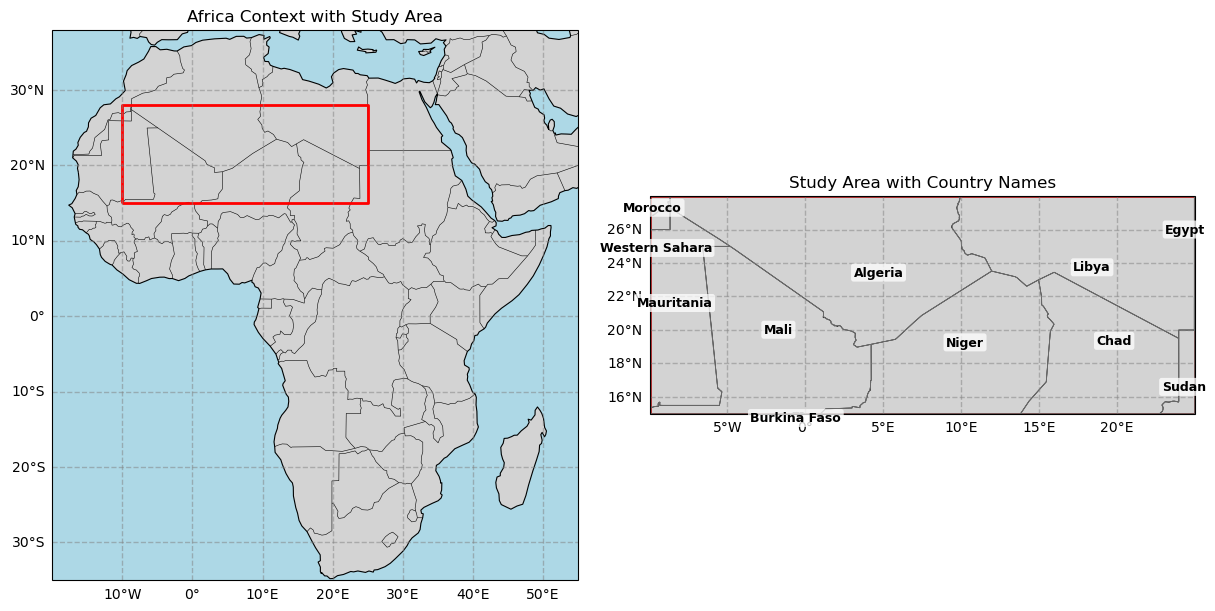

In [21]:

BBOX = [28.0, -10.0, 15.0, 25.0]
n, w, s, e = BBOX
proj = ccrs.PlateCarree()
study_poly = box(w, s, e, n)
study_gdf = gpd.GeoDataFrame(geometry=[study_poly], crs="EPSG:4326")

shp = shapereader.natural_earth(resolution="50m", category="cultural", name="admin_0_countries")
countries = gpd.read_file(shp).to_crs("EPSG:4326")
name_col = "NAME_EN" if "NAME_EN" in countries.columns else "NAME"

target_names = {
    "Mali", "Mauritania", "Algeria", "Niger", "Libya", "Chad",
    "Western Sahara", "Morocco", "Burkina Faso", "Sudan", "Egypt"
}

countries = countries[countries[name_col].isin(target_names) & countries.intersects(study_poly)].copy()
countries["geom_clip"] = countries.geometry.intersection(study_poly)
countries = countries.set_geometry("geom_clip").reset_index(drop=True)


countries["rep_pt"] = countries.geometry.representative_point()
countries["NAME_USE"] = countries[name_col]
manual_pos = {
   
    "Western Sahara": (-9.6, 24.9),  
    "Morocco":        (-9.8, 27.3),  
    "Egypt":          (24.4, 26.0),  
    "Sudan":          (24.3, 16.6),  
}

nudges = {
    "Burkina Faso": (0.0, -0.3),
    "Mauritania":   (-0.3,  0.2),
}

outside_labels = set()  

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(12, 6),
    subplot_kw={"projection": proj},
    constrained_layout=True
)

ax1.set_extent([-20, 55, -35, 38], crs=proj)  # [W, E, S, N]
ax1.add_feature(cfeature.LAND, color="lightgray")
ax1.add_feature(cfeature.OCEAN, color="lightblue")
ax1.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax1.add_feature(cfeature.BORDERS, linewidth=0.4)
study_gdf.boundary.plot(ax=ax1, color="red", linewidth=2)
ax1.set_title("Africa Context with Study Area")
gl1 = ax1.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.5)
gl1.top_labels = False; gl1.right_labels = False


ax2.set_extent([w, e, s, n], crs=proj)
ax2.add_feature(cfeature.LAND, color="lightgray")
ax2.add_feature(cfeature.OCEAN, color="lightblue")
ax2.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)


study_gdf.boundary.plot(ax=ax2, color="firebrick", linewidth=2)
countries.boundary.plot(ax=ax2, color="dimgray", linewidth=0.6)


for _, row in countries.iterrows():
    name = row["NAME_USE"]
    x0, y0 = row["rep_pt"].x, row["rep_pt"].y

   
    if name in manual_pos:
        x_lab, y_lab = manual_pos[name]
    else:
        dx, dy = nudges.get(name, (0.0, 0.0))
        x_lab, y_lab = x0 + dx, y0 + dy

    if name in outside_labels:
        x_out = e + 0.6  # outside right margin
        ax2.plot([x0, x_out - 0.15], [y0, y_lab], transform=proj, color="k", linewidth=0.6, alpha=0.8)
        x_lab = x_out

    ax2.text(
        x_lab, y_lab, name,
        transform=proj, ha="center", va="center",
        fontsize=9, weight="bold", color="black",
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.75),
        zorder=5,
    )

ax2.set_title("Study Area with Country Names")
gl2 = ax2.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.5)
gl2.top_labels = False; gl2.right_labels = False

plt.show()


*Figure 1.* Study domain for the Sahara analysis. Left: North Africa context with the red rectangle indicating the bounding box used for data extraction (28°N–15°N, 10°W–25°E; Plate Carrée projection). Right: Zoomed view of the box with national borders and labels (Morocco, Western Sahara, Mauritania, Mali, Algeria, Niger, Libya, Chad, Sudan, Egypt, and Burkina Faso) to indicate where changes are assessed.

#### Detect and visualize Sahara Desert expansion using albedo data (NDJF, 2006–2019) and produce an albedo change map (2019 − 2006).

We build NDJF (Nov–Feb) albedo composites for two epochs, 2006 from SPOT and 2019 from PROBA, using the same QC mask derived from the surface albedo QFLAG, as defined in the Product User Guide and Specification. According to this specification, Bit 4 flags pixels with missing or insufficient input data (“No data”), and Bit 7 flags pixels where the albedo retrieval algorithm failed; only pixels where both bits are 0 (normally processed) are retained via seasonal_mean_bits47. If 2019 NDJF is incomplete, we fall back to the latest available PROBA year. We then restrict all comparisons to the common valid footprint (valid_both). Pixel-wise change is computed as Δ = PROBA − SPOT. A pixel is flagged as “new desert” when (i) it was not desert in 2006, (ii) it is desert in 2019, and (iii) it brightened by at least min_delta = 0.02. “Desert” here means broadband hemispherical albedo > thr = 0.35. For context, we also mark pixels that brightened by >0.02 but remained below the threshold. Finally, the figure shows: (top left/right) the two NDJF albedo maps on a shared color scale with the threshold contour; and (bottom) a change map where red pixels are “new desert” (crossed the threshold), and pale yellow pixels brightened but stayed sub-threshold. 

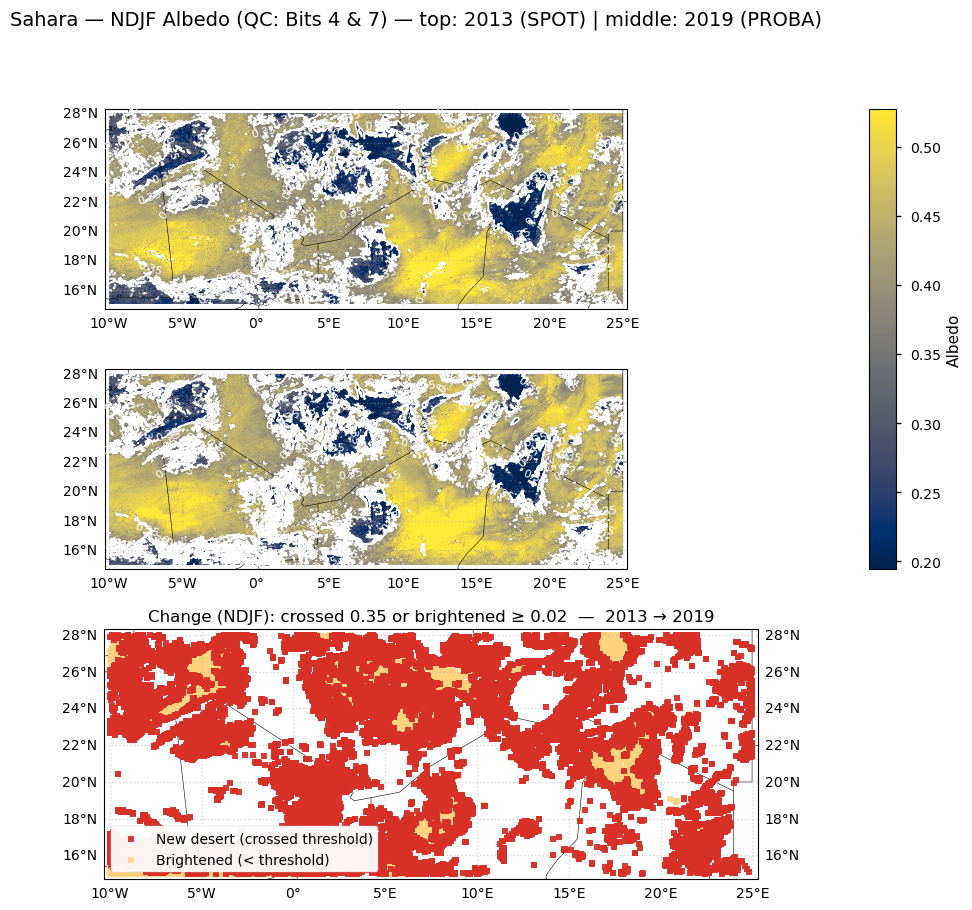

In [34]:
from matplotlib.gridspec import GridSpec
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 10))
gs  = GridSpec(
    3, 2,
    width_ratios=[30, 1],      # narrow right column for colorbar
    height_ratios=[1, 1, 1.25],
    hspace=0.28, wspace=0.25
)

fig.suptitle(
    f"Sahara — NDJF Albedo (QC: Bits 4 & 7) — "
    f"top: {year_spot} (SPOT) | middle: {year_proba} (PROBA)",
    y=0.98, fontsize=14
)


ax1 = fig.add_subplot(gs[0, 0], projection=proj)
im1 = spot_map.plot.pcolormesh(
    ax=ax1, transform=proj, cmap="cividis",
    vmin=vmin, vmax=vmax, add_colorbar=False
)
ax1.set_title(f"{year_spot} (SPOT) NDJF")
ax1.set_extent(extent, crs=proj)
ax1.coastlines("10m", linewidth=0.7)
ax1.add_feature(cfeature.BORDERS, linewidth=0.4)

cs1 = spot_map.plot.contour(
    ax=ax1, transform=proj, levels=[thr],
    colors="white", linewidths=1.1, add_colorbar=False
)
ax1.clabel(cs1, fmt=f"{thr:.2f}", fontsize=8)

gl1 = ax1.gridlines(draw_labels=True, linestyle=":", alpha=0.5)
gl1.top_labels = False
gl1.right_labels = False


ax2 = fig.add_subplot(gs[1, 0], projection=proj)
im2 = proba_map.plot.pcolormesh(
    ax=ax2, transform=proj, cmap="cividis",
    vmin=vmin, vmax=vmax, add_colorbar=False
)
ax2.set_title(f"{year_proba} (PROBA) NDJF")
ax2.set_extent(extent, crs=proj)
ax2.coastlines("10m", linewidth=0.7)
ax2.add_feature(cfeature.BORDERS, linewidth=0.4)

cs2 = proba_map.plot.contour(
    ax=ax2, transform=proj, levels=[thr],
    colors="white", linewidths=1.1, add_colorbar=False
)
ax2.clabel(cs2, fmt=f"{thr:.2f}", fontsize=8)

gl2 = ax2.gridlines(draw_labels=True, linestyle=":", alpha=0.5)
gl2.top_labels = False
gl2.right_labels = False


cax = fig.add_subplot(gs[0:2, 1])
cbar = fig.colorbar(im2, cax=cax)
cbar.set_label("Albedo")


ax3 = fig.add_subplot(gs[2, :], projection=proj)
ax3.set_extent(extent, crs=proj)
ax3.coastlines("10m", linewidth=0.7)
ax3.add_feature(cfeature.BORDERS, linewidth=0.4)

ax3.set_title(
    f"Change (NDJF): crossed {thr:.2f} "
    f"or brightened ≥ {min_delta:.02f}  —  "
    f"{year_spot} → {year_proba}"
)


ax3.pcolormesh(
    spot_map.longitude, spot_map.latitude,
    np.where(valid_both, 0, np.nan),
    transform=proj, cmap="Greys", vmin=0, vmax=1, alpha=0.05
)


ax3.scatter(
    nd_lon, nd_lat,
    s=24, c="#d73027", marker="s", lw=0,
    transform=proj, alpha=0.95,
    label="New desert (crossed threshold)", zorder=3
)

ax3.scatter(
    br_lon, br_lat,
    s=24, c="#ffd27f", marker="s", lw=0,
    transform=proj, alpha=0.9,
    label="Brightened (< threshold)", zorder=2
)

gl3 = ax3.gridlines(draw_labels=True, linestyle=":", alpha=0.5)
gl3.top_labels = False
gl3.left_labels = True
gl3.right_labels = True
gl3.bottom_labels = True

ax3.legend(loc="lower left", frameon=True, framealpha=0.95)

plt.show()


*Figure 2.* NDJF (Nov–Feb) broadband albedo over the Sahara in 2006 (SPOT, left) and 2019 (PROBA-V, right) after quality control (QFLAG bits 4 & 7: valid inputs and algorithm success). The lower panel highlights change between the two epochs: red pixels brightened by >0.02 and crossed above the 0.35 threshold (“new desert”), while yellow pixels brightened by >0.02 but remained below the threshold. Only the footprint valid in both years is considered.

#### Quantify desertification by country within the Sahara study domain.

To quantify desertification in each country inside the Sahara study domain, we (i) mapped pixels that became newly “desert-like” between 2006 and 2019 (crossing an albedo threshold in 2019 but not in 2006) after quality control, (ii) summed those pixels to km² using an equal-area projection, and (iii) normalized by each country’s own area within the study box to report an interpretable percentage of its in-box territory affected. To avoid distorted ratios from tiny border slivers, we filtered out countries with <10,000 km² inside the box. The resulting km² and % values reflect intensity of change within each country across the analyzed portion of the desert.

In [32]:

BBOX = [28.0, -10.0, 15.0, 25.0]
n, w, s, e = BBOX
study_poly = box(w, s, e, n)


df_cty = pd.DataFrame({
    "country": ["Mali","Mauritania","Algeria","Niger","Libya","Chad",
                "Western Sahara","Morocco","Burkina Faso","Sudan","Egypt"],
    "new_bright_km2": [37448,20062,18596,7164,3986,3826,364,323,181,99,13]
})


MIN_AREA_IN_BBOX = 10_000


EQUAL_AREA = "EPSG:6933"

shp = shapereader.natural_earth(resolution="50m", category="cultural", name="admin_0_countries")
gdf = gpd.read_file(shp).to_crs("EPSG:4326")
name_col = "NAME_EN" if "NAME_EN" in gdf.columns else "NAME"

targets = set(df_cty["country"])


gdf_targets = gdf[gdf[name_col].isin(targets)].copy()

gdf_targets_eq = gdf_targets.to_crs(EQUAL_AREA)
gdf_targets_eq["area_km2_country_total"] = gdf_targets_eq.geometry.area / 1e6
areas_total = gdf_targets_eq[[name_col, "area_km2_country_total"]].rename(columns={name_col: "country"})


gdf_clip = gdf_targets.copy()
gdf_clip["geom_clip"] = gdf_clip.geometry.intersection(study_poly)
gdf_clip = gdf_clip.set_geometry("geom_clip")


gdf_clip = gdf_clip[~gdf_clip.is_empty].copy()

gdf_clip_eq = gdf_clip.to_crs(EQUAL_AREA)
gdf_clip_eq["area_km2_in_bbox"] = gdf_clip_eq.geometry.area / 1e6
areas_bbox = gdf_clip_eq[[name_col, "area_km2_in_bbox"]].rename(columns={name_col: "country"})


out = (df_cty
       .merge(areas_bbox, on="country", how="left")
       .merge(areas_total, on="country", how="left"))


out["pct_of_country_in_bbox"] = 100.0 * out["new_bright_km2"] / out["area_km2_in_bbox"]


out["pct_of_whole_country"] = 100.0 * out["new_bright_km2"] / out["area_km2_country_total"]

full_cols = ["country", "new_bright_km2", "area_km2_in_bbox", "pct_of_country_in_bbox",
             "area_km2_country_total", "pct_of_whole_country"]
full_table = out[full_cols].copy()
full_table["new_bright_km2"] = full_table["new_bright_km2"].round(0).astype(int)
for c in ["area_km2_in_bbox", "area_km2_country_total"]:
    full_table[c] = full_table[c].fillna(0).round(0).astype(int)
for c in ["pct_of_country_in_bbox", "pct_of_whole_country"]:
    full_table[c] = full_table[c].round(2)

print("FULL TABLE — includes countries with tiny slices inside the box (may inflate %):")
print(full_table.sort_values("pct_of_country_in_bbox", ascending=False).to_string(index=False))


stable = out[out["area_km2_in_bbox"] >= MIN_AREA_IN_BBOX].copy()
stable["pct_of_country_in_bbox"] = 100.0 * stable["new_bright_km2"] / stable["area_km2_in_bbox"]
stable["pct_of_whole_country"]   = 100.0 * stable["new_bright_km2"] / stable["area_km2_country_total"]

stable_table = (stable[full_cols].copy())
stable_table["new_bright_km2"] = stable_table["new_bright_km2"].round(0).astype(int)
for c in ["area_km2_in_bbox", "area_km2_country_total"]:
    stable_table[c] = stable_table[c].round(0).astype(int)
for c in ["pct_of_country_in_bbox", "pct_of_whole_country"]:
    stable_table[c] = stable_table[c].round(2)

print(f"\nSTABLE REPORT — filtered to countries with ≥ {MIN_AREA_IN_BBOX:,} km² inside the study box:")
print(stable_table.sort_values("pct_of_country_in_bbox", ascending=False).to_string(index=False))


if not stable_table.empty:
    top = stable_table.sort_values("pct_of_country_in_bbox", ascending=False).head(3)
    bullets = []
    for _, r in top.iterrows():
        bullets.append(f"- {r['country']}: {r['pct_of_country_in_bbox']:.2f}% of its study-area footprint "
                       f"({r['new_bright_km2']:,} km² of {r['area_km2_in_bbox']:,} km²)")
    print("\nSummary (stable percentages):")
    print("\n".join(bullets))
    print("\nNote: percentages are relative to EACH COUNTRY’S AREA within the study box; "
          "tiny-slice countries were excluded to avoid misleading high ratios.")


FULL TABLE — includes countries with tiny slices inside the box (may inflate %):
       country  new_bright_km2  area_km2_in_bbox  pct_of_country_in_bbox  area_km2_country_total  pct_of_whole_country
  Burkina Faso             181               424                   42.65                  272627                  0.07
          Mali           37448            880150                    4.25                 1254111                  2.99
    Mauritania           20062            500134                    4.01                 1035382                  1.94
       Morocco             323             13461                    2.40                  581713                  0.06
Western Sahara             364             15575                    2.34                   90593                  0.40
       Algeria           18596           1198624                    1.55                 2319300                  0.80
         Egypt              13              1324                    0.98              

#### Validate newly identified desert pixels and inspect their albedo values.

The analysis combines the NDJF albedo maps for 2006 and 2019 into a single comparative table, keeps only pixels that are valid in both years, and then selects the ones that became desert by our rule (2019 albedo > thr, 2006 albedo ≤ thr, and increase ≥ min_delta). It then (a) counts how many pixels meet all three conditions, (b) summarizes their values with min/median/max and percentiles for 2006 albedo, 2019 albedo, and the change (Δ), and (c) prints a small random sample showing latitude, longitude, 2006 albedo, 2019 albedo, and Δ for quick spot-checks.

In [46]:
import pandas as pd
import xarray as xr
import numpy as np

def to_df(da: xr.DataArray, name: str) -> pd.DataFrame:
    return da.rename(name).to_dataset().to_dataframe().reset_index()


a06 = xr.DataArray(
    spot_map.values,
    coords=[spot_map.latitude, spot_map.longitude],
    dims=["latitude", "longitude"],
)
a19 = xr.DataArray(
    proba_map.values,
    coords=[proba_map.latitude, proba_map.longitude],
    dims=["latitude", "longitude"],
)
dlt = xr.DataArray(a19.values - a06.values, coords=a06.coords, dims=a06.dims)
msk = xr.DataArray(new_desert, coords=a06.coords, dims=a06.dims)
vld = xr.DataArray(valid_both, coords=a06.coords, dims=a06.dims)


df = pd.concat(
    [
        to_df(a06, "albedo_2006"),
        to_df(a19, "albedo_2019")["albedo_2019"],
        to_df(dlt, "delta")["delta"],
        to_df(msk, "new_desert")["new_desert"],
        to_df(vld, "valid_both")["valid_both"],
    ],
    axis=1,
)

df = df.query("valid_both and new_desert").drop(columns=["new_desert", "valid_both"])


df["check_2019_gt_thr"] = df["albedo_2019"] > thr
df["check_2006_le_thr"] = df["albedo_2006"] <= thr
df["check_delta_gt_min"] = df["delta"] > min_delta


cols_num = ["latitude", "longitude", "albedo_2006", "albedo_2019", "delta"]
df_display = df.copy()
df_display[cols_num] = df_display[cols_num].astype(float).round(2)


df_display.head(10)





,latitude,longitude,albedo_2006,albedo_2019,delta,check_2019_gt_thr,check_2006_le_thr,check_delta_gt_min
209,28.0,-8.13,0.35,0.37,0.02,True,True,True
210,28.0,-8.12,0.34,0.36,0.02,True,True,True
211,28.0,-8.12,0.35,0.37,0.02,True,True,True
1154,28.0,0.30,0.32,0.36,0.04,True,True,True
1155,28.0,0.31,0.31,0.35,0.04,True,True,True
1159,28.0,0.35,0.32,0.35,0.03,True,True,True
1160,28.0,0.36,0.32,0.36,0.04,True,True,True
1161,28.0,0.37,0.32,0.37,0.05,True,True,True
1162,28.0,0.38,0.32,0.37,0.04,True,True,True
1163,28.0,0.38,0.32,0.36,0.04,True,True,True


#### Perform pixel-count analysis comparing summer albedo maps (2006 vs. 2019).

In [45]:
# All rows should pass these:
n_all   = len(df)
n_good  = (df["check_2019_gt_thr"] & df["check_2006_le_thr"] & df["check_delta_gt_min"]).sum()
print(f"New-desert rows: {n_all:,}  |  Fully consistent with rules: {n_good:,}")


print("\nAlbedo (2006) — min/median/max:", df["albedo_2006"].min(), df["albedo_2006"].median(), df["albedo_2006"].max())
print("Albedo (2019) — min/median/max:", df["albedo_2019"].min(), df["albedo_2019"].median(), df["albedo_2019"].max())
print("Delta         — min/median/max:", df["delta"].min(), df["delta"].median(), df["delta"].max())

for p in (5, 25, 50, 75, 95):
    print(f"p{p:02d} 2006/2019/delta:",
          np.round(df['albedo_2006'].quantile(p/100), 3),
          np.round(df['albedo_2019'].quantile(p/100), 3),
          np.round(df['delta'].quantile(p/100),       3))

cols = ["latitude","longitude","albedo_2006","albedo_2019","delta"]
print(df[cols].sample(10, random_state=42).round(3))


New-desert rows: 55,644  |  Fully consistent with rules: 55,644

Albedo (2006) — min/median/max: 0.03830000013113022 0.335099995136261 0.3499999940395355
Albedo (2019) — min/median/max: 0.3500000238418579 0.3654000163078308 0.5915249586105347
Delta         — min/median/max: 0.02000001072883606 0.030000001192092896 0.47872495651245117
p05 2006/2019/delta: 0.308 0.352 0.021
p25 2006/2019/delta: 0.327 0.358 0.024
p50 2006/2019/delta: 0.335 0.365 0.03
p75 2006/2019/delta: 0.343 0.373 0.04
p95 2006/2019/delta: 0.348 0.39 0.061
         latitude  longitude  albedo_2006  albedo_2019  delta
5155039    16.259     -7.866        0.327        0.378  0.051
1259821    25.134      3.402        0.323        0.360  0.038
5557984    15.348     19.857        0.329        0.401  0.072
1910388    23.652      2.036        0.348        0.374  0.025
5037371    16.527     -8.473        0.329        0.368  0.039
5589356    15.277     19.964        0.315        0.352  0.037
5301462    15.929      4.482        0.

(section-4)=
### 4. Take-home messages

• Using threshold of surface albedo of 0.35 to separate desert from non-desert areas combined with a increase of surface brightening Δ= surface albedo2019 - surface albedo2006 > 0.02, the year 2019 shows a small expansions of the desert compared to the year 2006, which occurs in different countries in the region and it is larger in Mali and Mauritania.
• Pixel-level verification confirms that the flagged locations satisfying the selection rules (surface albedo2019 > 0.35, surface albedo2006 ≤ 0.35, and Δ > 0.02) show values of Δ in the 0.02–0.08 range.

## ℹ️ If you want to know more
### References

[[1]](https://doi.org/10.1175/JCLI-D-17-0187.1)  Thomas, N., & Nigam, S. (2018). *Twentieth-Century Climate Change over Africa: Seasonal Hydroclimate Trends and Sahara Desert Expansion*. **Journal of Climate**, 31(9), 3349–3370.

[[2]](https://doi.org/10.3390/rs10101541)  Gómez, D., Salvador, P., Sanz, J., & Casanova, J. L. (2018). *Detecting Areas Vulnerable to Sand Encroachment Using Remote Sensing and GIS Techniques in Nouakchott (Mauritania)*. **Remote Sensing**, 10(10), 1541.

[[3]](https://doi.org/10.3390/su13147953)  Benhizia, R., Akermi, S., & Bouguerra, H. (2021). *Monitoring the Spatiotemporal Evolution of the Green Dam in Djelfa Province, Algeria (1972–2019)*. **Sustainability**, 13(14), 7953.

[[4]](https://doi.org/10.1016/j.catena.2019.104094)  Touré, A. A., Bilal, B., Tidjani, A. D., & Karimoune, S. (2019). *Dynamics of wind erosion and impact of vegetation cover and land use in the Sahel: A case study on sandy dunes in southeastern Niger*. **Catena**, 181, 104094.

[[5]](https://doi.org/10.5194/isprsarchives-XL-7-W3-1375-2015)  Els, A., Mayer, P., & Cooksley, G. (2015). *Comparison of Two Satellite Imaging Platforms for Evaluating Sand Dune Migration in the Ubari Sand Sea (Libya)*. **The International Archives of the Photogrammetry, Remote Sensing and Spatial Information Sciences**, XL-7/W3, 1375–1382.

[[6]](https://doi.org/10.5897/AJEST2015.1958)  Abdoulkader, M. I., Tidjani, A. D., & Aboubakar, I. (2016). *Spatial dynamics of mobile dunes, soil crusting and Yobe’s bank retreat in the Niger’s Lake Chad basin (cases of Issari and Bagara)*. **African Journal of Environmental Science and Technology**, 10(6), 151–161.